# Gradient descent density matrix learning
Created 08/05/2024

Objectives:
* As seen in [this notebook](gradient_descent.ipynb), gradient descent is struggling with learning the solution, but fine with unitarizing. However we know the solution is a unitarized version of the density matrix. So can we learn the density matrix first, then unitarize?

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [3]:
from functools import reduce
from operator import mul
from collections import namedtuple

import time
import pickle

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
import matplotlib.pyplot as plt

import scipy

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    multiply_transfer_matrices,
    to_npc_array,
    get_physical_dim
)

from SPTOptimization.mpo_utils import (
    mpo_socket_tensor_contraction
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import (
    SymmetryActionWithBoundaryUnitaries
)

from SPTOptimization.Optimizers.MPOGradientDescent import (
    MPOGradientDescent
)

# Load data

In [8]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [9]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [10]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [11]:
psi = loaded_data_non_triv_proj_rep[0.45]

# Definitons

In [12]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [13]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [14]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [15]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [16]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [17]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [18]:
fermionic_np_symmetries = [np_I, np_JW]

In [19]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [20]:
npc_JW = fermionic_npc_symmetries[1]

In [21]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [22]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [23]:
s = symmetry_actions[0][1]

case = SymmetryActionWithBoundaryUnitaries(
    psi,
    s*40,
    left_symmetry_index=60,
    left_boundary_unitaries=[np_I, np_00]*1,
    right_boundary_unitaries=[np_00, np_I]*1
)

In [24]:
case.compute_svd_approximate_expectation()

(-7.171141509766298e-28-4.647688751856734e-31j)

## Functions

In [25]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [26]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1)
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1)

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [27]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [28]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [29]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    # First site
    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.replace_label('vL', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    # Inner sites
    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    # Last site
    b = b_tensors[0]
    w = w_tensors[0]

    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w,
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    return out[::-1]

In [30]:
l = list(range(10))

In [31]:
def contracted_right_tensors_mpo(w_tensors_1, w_tensors_2):
    out = list()

    out.append(t)

    # First site
    w1 = w_tensors_1[-1].replace_label('vL', 'vL1')
    w2 = w_tensors_2[-1].replace_label('vL', 'vL2')
    
    t = npc.tensordot(w1, w2, [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    # Inner sites
    for w1, w2 in zip(w_tensors_1[-2::-1], w_tensors_1[-2::-1]):
        w1 = w1.replace_label('vL', 'vL1')
        w2 = w2.replace_label('vL', 'vL2')
        t = npc.tensordot(t, w1, [['vL1',], ['vR',]])
        t = npc.tensordot(
            t,
            w2,
            [['vL2', 'p', 'p*'], ['vR', 'p*', 'p']]
        )
  
        out.append(t)

    return out[::-1]

### Initialize tensors

In [32]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [33]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [34]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [35]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [36]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [37]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [38]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [39]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [40]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Error functions

In [41]:
def trace_rdm_rdm_conj(b_tensors, left_environment):
    unitaries = [None for _ in b_tensors]

    def sub_tm(b):
        return npc.tensordot(b, b.conj(), [['p',], ['p*',]])

    transfer_matrices = (sub_tm(b) for b in b_tensors)

    full_tm = reduce(multiply_transfer_matrices, transfer_matrices)

    t = npc.tensordot(
        full_tm.replace_labels(['vL', 'vL*'], ['vLU', 'vLU*']),
        full_tm.replace_labels(['vL', 'vL*'], ['vLD', 'vLD*']),
        [['vR', 'vR*'], ['vR*', 'vR']]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vLU', 'vLD*'], ['vR', 'vR*']]
    )

    out = npc.tensordot(
        t,
        left_environment.conj(),
        [['vLU*', 'vLD'], ['vR*', 'vR']]
    )

    return out

### Sweep function

In [42]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [43]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [44]:
def mpo_rdm_gradient_descent_sweep(mpo_tensors, b_tensors, total_dimension,
    right_overlap_tensors, left_environment, adam_optimizers, rdm_rdm_conj_norm_squared):
    """
    Really need to tidy this function up...

    COMMENT!
    
    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()

    # Initialise variables
    right_contracted_mpo_tensors = unitary_order_two_right_tensors(mpo_tensors)
    #right_overlap_tensors = overlap_right_tensors(mpo_tensors, b_tensors)
    
    left_contracted_mpo_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_contracted_mpo_tensors[0]

    # MPO terms
    # Below line should break? Bad leg indices?
    grad_mpo = npc.tensordot(t, w, [['vL'], ['vR',]])

    mpo_score = mpo_socket_tensor_contraction(
        grad_mpo,
        w.conj(),
        [['vL*',], ['vR*',]]
    )
    grad_mpo = mpo_tensor_raw_to_gradient(grad_mpo, w)

    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment.conj(), [['vL', 'vL*'], ['vR', 'vR*']])

    o_score = mpo_socket_tensor_contraction(
        grad_o,
        w.conj(),
        [['vLm',], ['vR*',]]
    )
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    score = mpo_score - 2*o_score.real + rdm_rdm_conj_norm_squared
    # Can these add? Do they have the same leg index?
    #print(grad_mpo)
    #print(grad_o)
    grad = grad_mpo - grad_o

    """
    score=update_mpo_score(
        grad,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    """
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_contracted_mpo_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment.conj(), [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_contracted_mpo_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_contracted_mpo_tensors[-1]

        grad_mpo = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_mpo = npc.tensordot(grad_mpo, left_two_tensor, [['vL'], ['vR',]])

        grad_mpo = mpo_tensor_raw_to_gradient(grad_mpo, w)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (grad_mpo - grad_o)

        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_contracted_mpo_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_contracted_mpo_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_mpo = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_mpo = mpo_tensor_raw_to_gradient(grad_mpo, w)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (grad_mpo - grad_o)
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g

    score = 0
    for g in grads:
        X = g.to_ndarray()
        out = np.sum(X*(X.conj()))
        score += out
    """
    
    return (grads, score)

In [45]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [46]:
def two_sided_mpo_rdm_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, symmetry_transfer_matrix, left_adam_optimizers,
    right_adam_optimizers):
    
    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    right_rdm_rdm_conj_norm_squared = trace_rdm_rdm_conj(
        right_b_tensors, left_symmetry_environment
    )

    # Get right gradients
    right_grads, right_score = mpo_rdm_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        left_symmetry_environment,
        right_adam_optimizers,
        right_rdm_rdm_conj_norm_squared
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    left_rdm_rdm_conj_norm_squared = trace_rdm_rdm_conj(
        left_b_tensors, right_symmetry_environment
    )

    # Get left gradients
    left_grads, left_score  = mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        right_symmetry_environment,
        left_adam_optimizers,
        left_rdm_rdm_conj_norm_squared
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (left_score, right_score)

In [47]:
def two_sided_mpo_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, unitarity_learning_rate, overlap_learning_rate,
    symmetry_transfer_matrix, left_adam_optimizers, right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, unitary_score, c_abs = mpo_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, *_ = mpo_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (unitary_score, c_abs)

In [48]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [49]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

In [50]:
def initialize_optimization(num_sites, bond_dimension, symmetry_case,
    unitarity_learning_rate, overlap_learning_rate, adam_params):
    right_b_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    left_b_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for i in range(
            symmetry_case.left_symmetry_index - 1,
            symmetry_case.left_symmetry_index - 1 - num_sites, -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b) for b in left_b_tensors
    ]

    right_physical_dims = [
        get_physical_dim(b) for b in right_b_tensors
    ]
    
    right_total_dimension = reduce(mul, right_physical_dims)

    left_physical_dims = [
        get_physical_dim(b) for b in left_b_tensors
    ]

    left_total_dimension = reduce(mul, left_physical_dims)

    virtual_dims = (
        [(None, bond_dimension),] +
        [(bond_dimension, bond_dimension)]*(num_sites - 2) +
        [(bond_dimension, None),]
    )

    right_mpo_tensors = get_random_mpo_tensors(
        right_physical_dims,
        virtual_dims
    )
    left_mpo_tensors = get_random_mpo_tensors(
        left_physical_dims,
        virtual_dims
    )
    rescale_mpo_tensors(right_mpo_tensors, 1)
    rescale_mpo_tensors(left_mpo_tensors, 1)

    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    left_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    right_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    return (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

### SPT phase extraction

In [51]:
def conjugate_single_mpo_tensor(mpo_tensor):
    leg_labels = mpo_tensor.get_leg_labels()

    if not ('vR' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vL*',], ['vL',])
    elif not ('vL' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vR*'], ['vR'])
    else:
        return mpo_tensor.conj().replace_labels(['vL*', 'vR*'], ['vL', 'vR'])

In [52]:
def conjugate_mpo(mpo_tensors):
    return [
        conjugate_single_mpo_tensor(t) for t in mpo_tensors
    ]

In [53]:
def mpo_product_expectation(left_environment, b_tensors, mpos):
    """
    Have an optional b_conj argument? Left and right arguments?

    Like a previous function we wrote?
    """

    # First site
    t = b_tensors[0]

    for i, l in enumerate(mpos):
        w = l[0]
        t = npc.tensordot(
            t,
            w.replace_label('vR', f'vR{i}'),
            [['p',], ['p*',]]
        )

    t = npc.tensordot(
        t,
        b_tensors[0].conj(),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    # Inner sites
    for i in range(1, len(b_tensors)-1):
        t = npc.tensordot(
            t,
            b_tensors[i],
            [['vR',], ['vL',]]
        )

        for j, l in enumerate(mpos):
            w = l[i]
            t = npc.tensordot(
                t,
                w.replace_label('vR', f'vR{j}'),
                [['p', f'vR{j}'], ['p*', 'vL']]
            )
    
        t = npc.tensordot(
            t,
            b_tensors[i].conj(),
            [['p', 'vR*'], ['p*', 'vL*']]
        )

    # Last site
    t = npc.tensordot(
        t,
        b_tensors[-1],
        [['vR',], ['vL',]]
    )

    for i, l in enumerate(mpos):
        w = l[-1]
        t = npc.tensordot(
            t,
            w,
            [['p', f'vR{i}'], ['p*', 'vL']]
        )

    t = npc.tensordot(
        t,
        b_tensors[-1].conj(),
        [['p', 'vR*', 'vR'], ['p*', 'vL*', 'vR*']]
    )

    return t

In [54]:
def proj_rep_phase(left_environment, b_tensors, mpo_1, mpo_2, mpo_3):
    num = mpo_product_expectation(
        left_environment,
        b_tensors,
        [
            mpo_1,
            mpo_2,
            conjugate_mpo(mpo_3)
        ]
    )

    den = npc.trace(left_environment)

    return num/den

# Checks

## 1

In [55]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (5e-4, 0.35, 0.35)

In [56]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

137.47185802459717


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


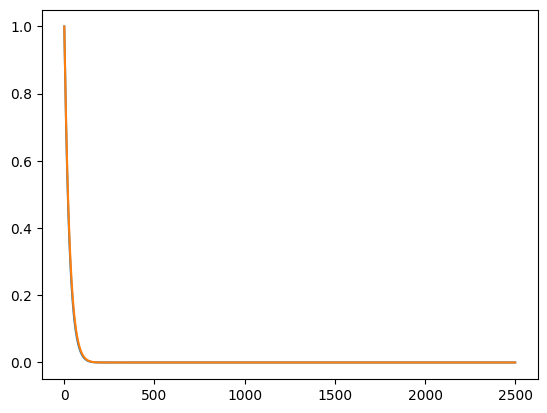

In [57]:
plt.plot(left_scores)
plt.plot(right_scores)

In [58]:
(left_scores[-1], right_scores[-1])

((3.4150760632114506e-12-6.8319948718172e-23j),
 (9.173140112652416e-12-1.6327931368686075e-23j))

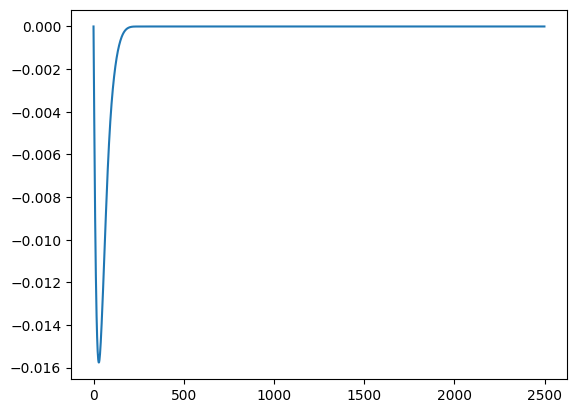

In [59]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [61]:
unitarity_learning_rate = 1
overlap_learning_rate = 30

num_iterations = int(1e4)

In [62]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [63]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [64]:
adam_params = (1e-3, 0.35, 0.35)

In [66]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.99999999998175
1.210322010481715e-18
100
511.9717033299916
2.7685912529601943e-09
200
265.64938874598886
8.378165069695269e-05
300
1.2749076699201396
7.107700948340039e-05
400
0.3394508984725917
7.040234829790814e-05
500
0.15250978466610832
6.939978570752656e-05
600
0.12962759441234084
6.824966597018482e-05
700
0.21652793108034984
6.78129269435732e-05
800
0.22915693968968753
6.818547512601962e-05
900
0.043665758818747236
6.931541848126762e-05
1000
0.1480794263459302
7.038979067199654e-05
1100
0.22938983619746978
7.057383550181418e-05
1200
0.09449247181066767
7.04320168964416e-05
1300
0.04909068856511567
7.196882736135839e-05
1400
0.0381267898974329
7.191131041969906e-05
1500
0.048534675752875955
7.149021755446574e-05
1600
0.08806609622189399
7.295913222665004e-05
1700
0.3636298318514264
7.223611130617901e-05
1800
0.2513406129753548
7.271699209632526e-05
1900
0.14744904333571185
7.359547764442896e-05
2000
0.024368166132546776
7.405665964809996e-05
2100
0.03712233577579127
7.479389

KeyboardInterrupt: 

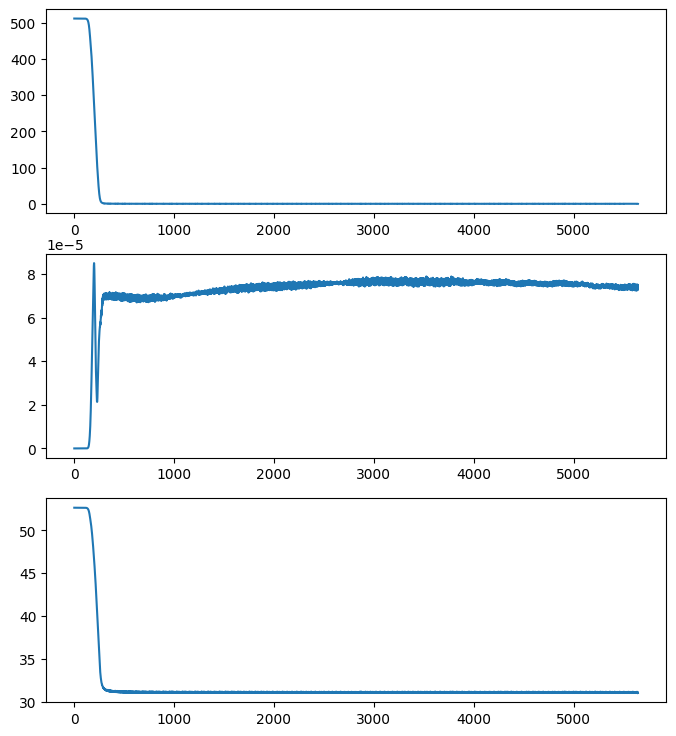

In [67]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

## 2

In [74]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [75]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

125.17715525627136


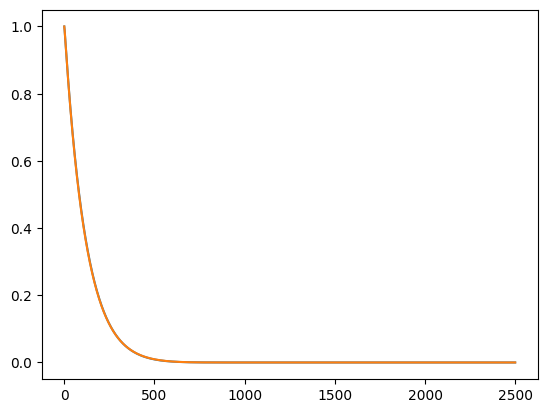

In [76]:
plt.plot(left_scores)
plt.plot(right_scores)

In [77]:
(left_scores[-1], right_scores[-1])

((7.256746254223387e-09-3.044024654441661e-22j),
 (2.0917970518096202e-08-2.1705219273299e-21j))

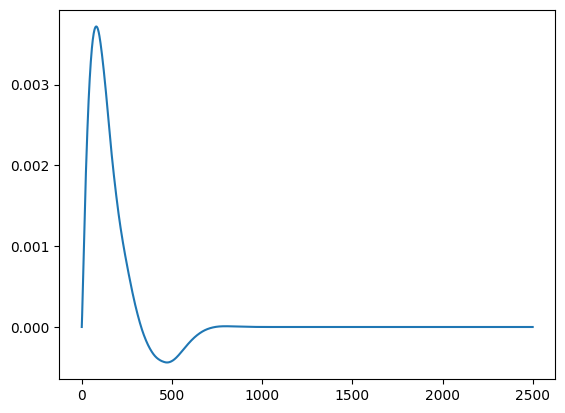

In [78]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [79]:
unitarity_learning_rate = 1
overlap_learning_rate = 30

num_iterations = int(1e4)

In [80]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [81]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [82]:
adam_params = (1e-4, 0.5, 0.5)

In [83]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.99999995848157
2.362255152371917e-15
100
511.9539978483784
2.3101548796330273e-09
200
498.0116195761718
5.29571876809895e-07
300
345.05577432207184
1.230930388327828e-05
400
115.22242592344577
8.917792641189156e-06
500
99.79621668828258
7.454718055069897e-05
600
50.355108587541565
6.45584829123836e-05
700
51.97027833581012
6.379535806451449e-05
800
158.4478415792654
6.921192289405703e-05
900
978.990237231545
4.896252026589071e-05
1000
2759.1085480296974
0.00022846160769482944
1100
11046.220205508564
0.000166911857984671
1200
41528.639515965384
0.0004892978662573855
1300
134097.39459807097
0.0003985689520812305
1400
499283.9452924502
0.0007369002798541668
1500
1949532.0635487519
0.0006468248664925167
1600
6752272.601050443
0.0007473988383847385
1700
20020439.36088205
0.0011068262752719907
1800
63968193.72826466
0.0031113992807082994
1900
248634494.7720883
0.004334681579039669
2000
663336998.620147
0.0036146490619610137
2100
1846607734.3129923
0.0063045378687528065
2200
5741497491.

KeyboardInterrupt: 

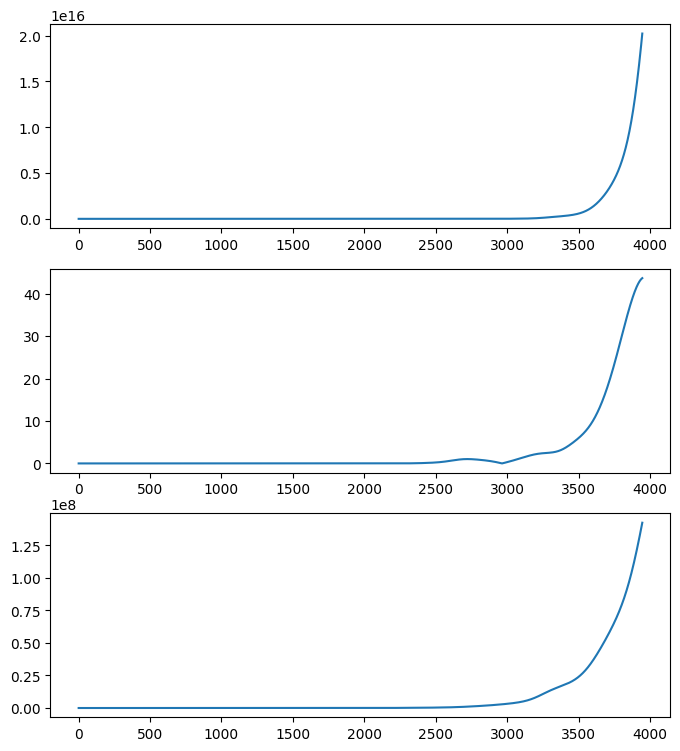

In [84]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

## 3

In [85]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [86]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

150.92154693603516


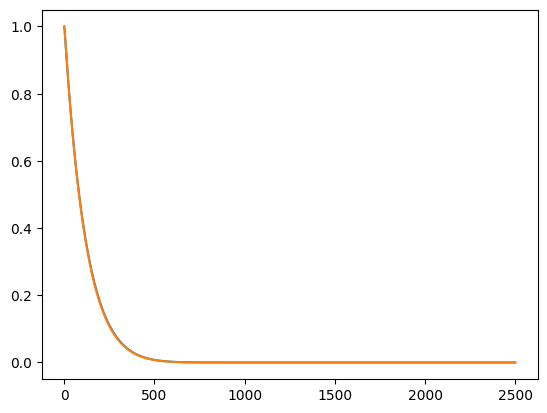

In [87]:
plt.plot(left_scores)
plt.plot(right_scores)

In [88]:
(left_scores[-1], right_scores[-1])

((6.450931888014397e-08-2.038173029367638e-21j),
 (3.951280158250046e-08-6.114519088000455e-21j))

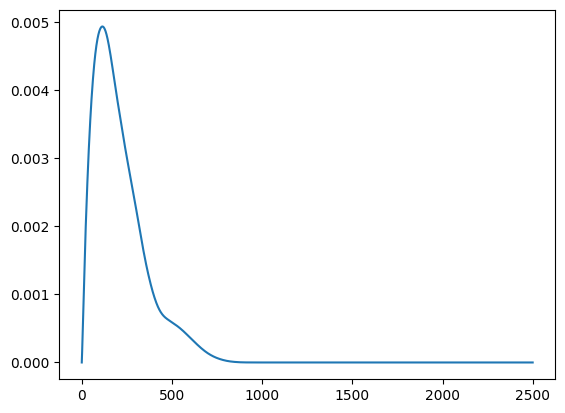

In [89]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [91]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
overlap_learning_rate = 30

num_iterations = int(1e4)

In [92]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [93]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [94]:
adam_params = (1e-4, 0.45, 0.45)

In [95]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.9999999208814
2.0687254889311144e-15
100
511.99816424094587
1.0932027788711428e-10
200
511.94230322928047
1.9964518189460465e-09
300
511.35105749452737
9.183115485273332e-09
400
507.2845371597777
1.5812414295816786e-07
500
488.62921756655993
1.5552114166825125e-06
600
452.3022760504121
4.907243246155886e-06
700
398.95847659237495
4.677358412493926e-06
800
320.6430358619291
6.2167359197932545e-06
900
226.3257732885309
1.6662820308546554e-05
1000
138.80266867493685
3.158109549132256e-05
1100
70.37853047165231
2.8775009723350036e-05
1200
21.69121544405516
3.246790691109401e-05
1300
4.174331904951487
3.458932949193314e-05
1400
0.7700780988628821
4.399907798586167e-05
1500
0.1303891309691494
4.991970266018446e-05
1600
0.045977895528722
5.229323109489679e-05
1700
0.026564620156932506
5.458680927997417e-05
1800
0.018877910615685778
5.6796168906089225e-05
1900
0.01455422996298239
5.864754728887865e-05
2000
0.0119428883313617
6.077821496885053e-05
2100
0.010036595212113752
6.3061882604228

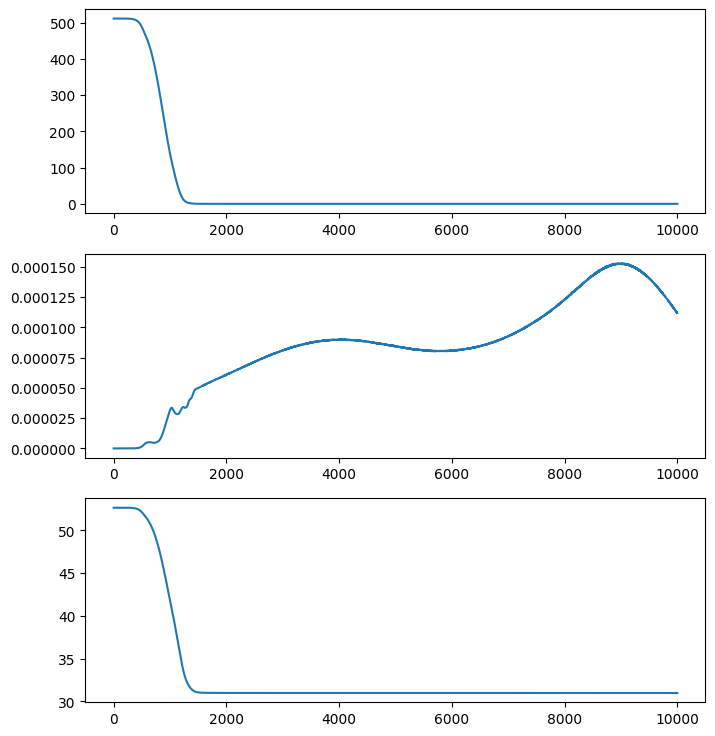

In [96]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

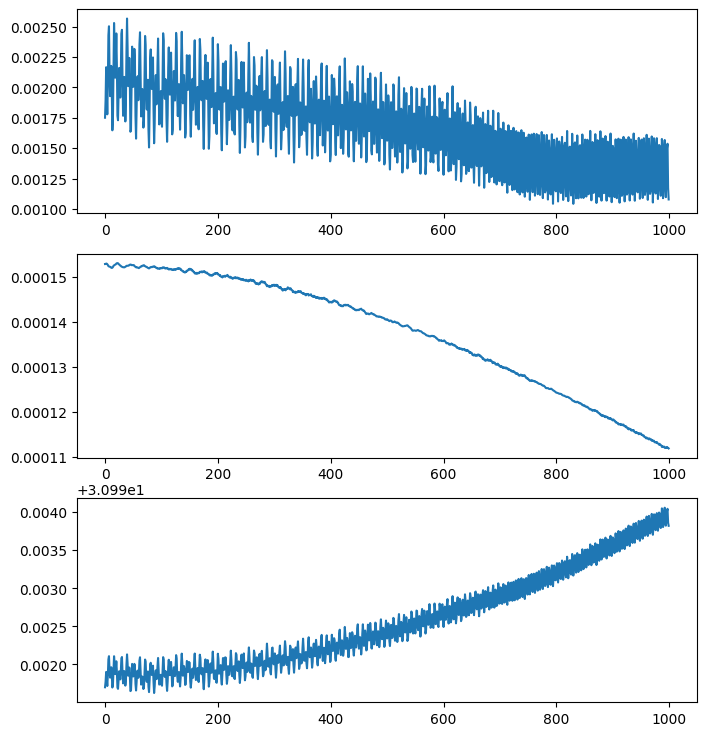

In [97]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[-1000:])
ax2.plot(opt.mpo_expectations[-1000:])
ax3.plot(opt.training_losses[-1000:])

In [98]:
for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
0.001360564973936107
0.00011174951859858193
100
0.0015207510343202557
0.00010517352312260883
200
0.0014389105529630797
9.859767292561764e-05
300
0.0015445525444874875
9.218952779562519e-05
400
0.0016085681454569567
8.607230877205972e-05
500
0.001418009195333525
8.032245361751393e-05
600
0.0011672962796183128
7.500625774074218e-05
700
0.001118244637382304
7.000169695390854e-05
800
0.0010194124361078138
6.562249605343753e-05
900
0.0010169755140623238
6.171400188347108e-05
1000
0.001042755893422509
5.809782076386918e-05
1100
0.0012210060152710867
5.51713707618846e-05
1200
0.0014977895739320957
5.264078831043832e-05
1300
0.0015655893784014552
5.029535192349796e-05
1400
0.0014841660521938138
4.8570514781097324e-05
1500
0.0014560810478201347
4.679669048624212e-05
1600
0.001442269375104388
4.5266715503986256e-05
1700
0.0013237610752412365
4.401683098958993e-05
1800
0.00122732331141151
4.284090388507191e-05
1900
0.0012028508888306533
4.1513413701206356e-05
2000
0.0011211721841846156
3.990624

KeyboardInterrupt: 

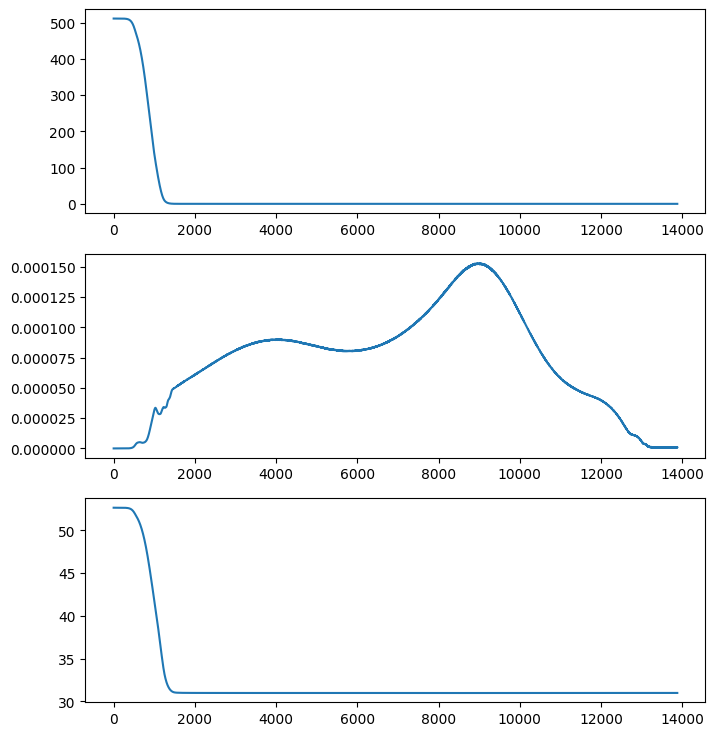

In [99]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

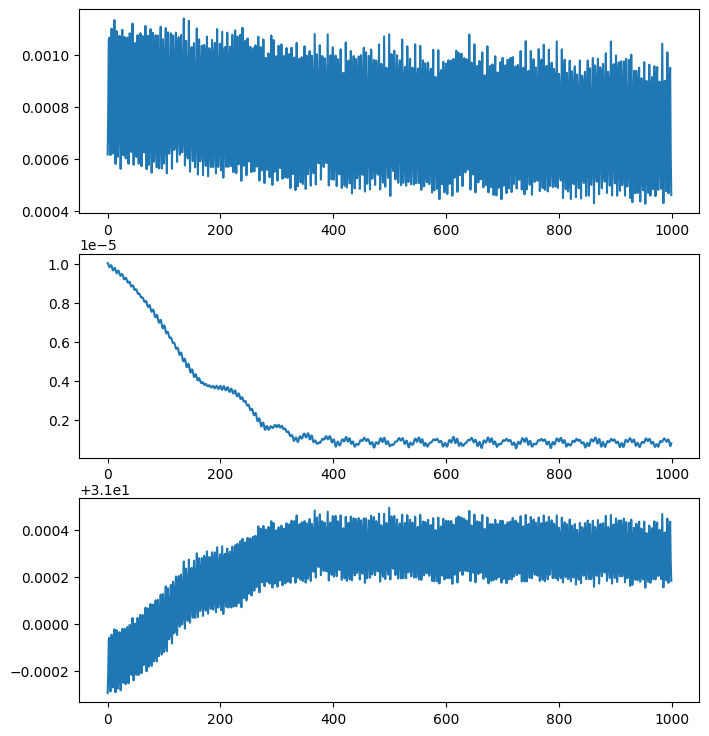

In [100]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[-1000:])
ax2.plot(opt.mpo_expectations[-1000:])
ax3.plot(opt.training_losses[-1000:])

## 4

In [101]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [102]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

108.5514509677887


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


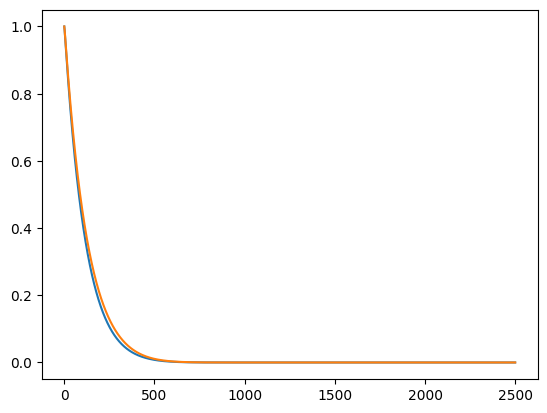

In [103]:
plt.plot(left_scores)
plt.plot(right_scores)

In [104]:
(left_scores[-1], right_scores[-1])

((4.2492796862521716e-08-1.0680556069372516e-20j),
 (4.9289709425214043e-08+4.7777952181802436e-21j))

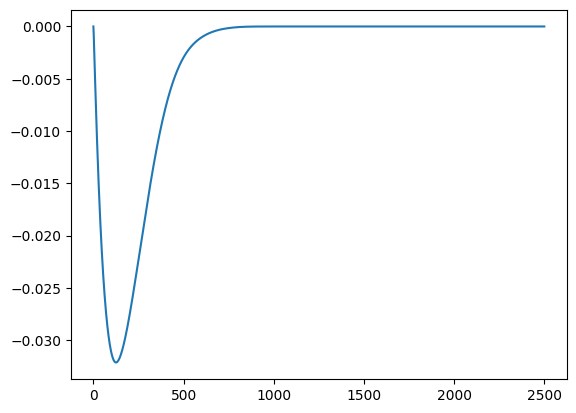

In [105]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [106]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
unitarity_shape_parameter = 0.2
overlap_learning_rate = 100

num_iterations = int(1e4)

In [107]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [108]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [109]:
adam_params = (1e-4, 0.45, 0.45)

In [110]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.9999999023967
1.743202314578896e-14
100
511.998245951997
9.216592656526566e-11
200
511.947950543758
5.105443530206357e-10
300
511.4170537176264
1.4511426176559847e-08
400
507.7253602158788
3.887688273748769e-07
500
490.27955911247693
4.167259668233639e-06
600
456.030189445434
1.690561277341976e-05
700
403.7021513247268
4.1052484852313374e-05
800
320.8093690622848
8.115990153367714e-05
900
210.63519225764918
0.00013310508505207533
1000
103.94131511034078
0.00021122572691206515
1100
32.64059881290797
0.0002812166744603515
1200
8.14267014930573
0.0002736437895843879
1300
1.89602899985249
0.0002875816233074691
1400
0.38711331068515165
0.0003593284938668305
1500
0.11417908630875218
0.00046887363811860003
1600
0.05768604304500968
0.0005302923316528349
1700
0.039969419011413265
0.0005948865865715356
1800
0.032290940135908386
0.0007362261439466144
1900
0.029508725203641006
0.0008889574739594487
2000
0.028248253304695936
0.001015647506041963
2100
0.02896535931267863
0.0011891033344356024


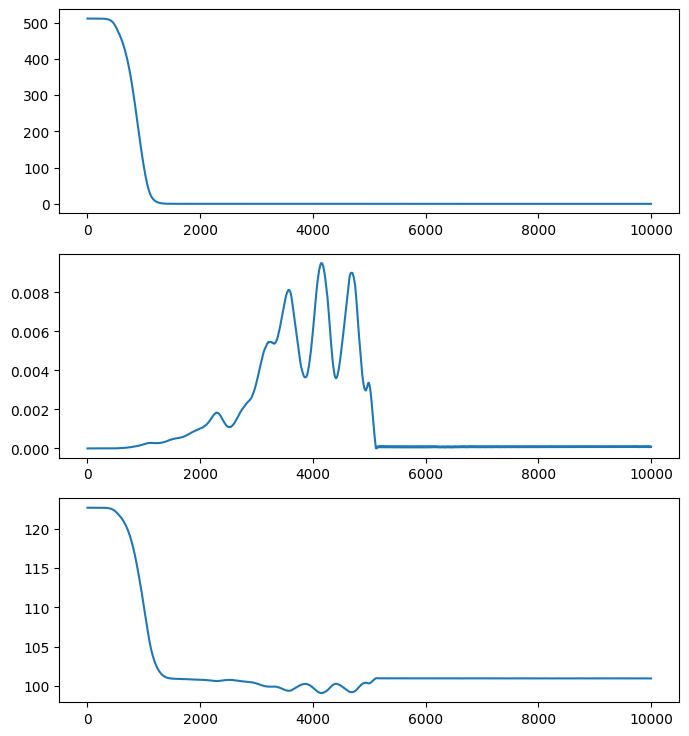

In [111]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

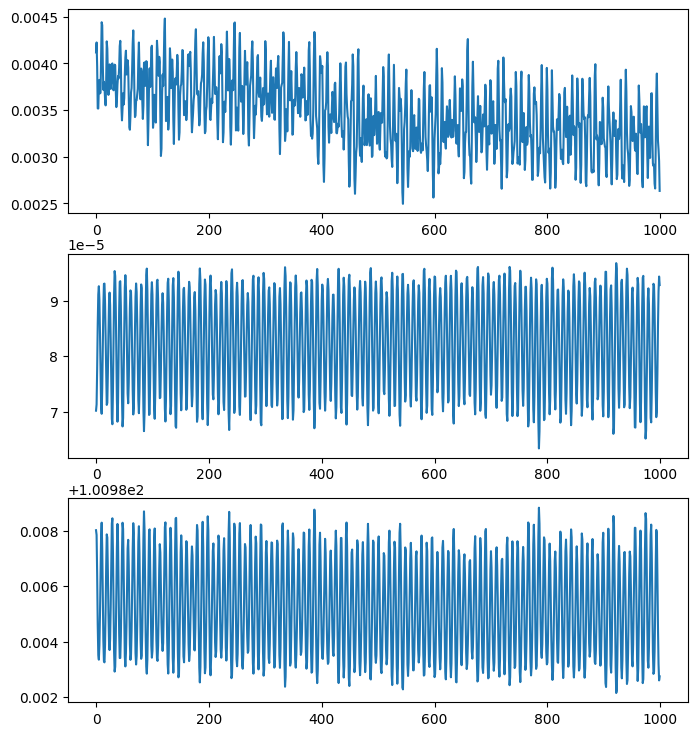

In [112]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[-1000:])
ax2.plot(opt.mpo_expectations[-1000:])
ax3.plot(opt.training_losses[-1000:])

## 5

In [113]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [114]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

129.16600608825684


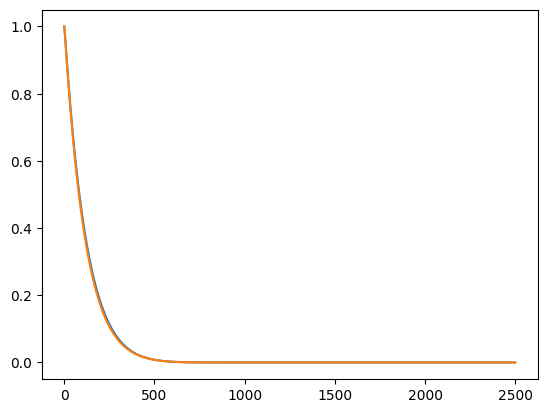

In [115]:
plt.plot(left_scores)
plt.plot(right_scores)

In [116]:
(left_scores[-1], right_scores[-1])

((3.313575742032367e-09+1.0728532545305807e-21j),
 (5.5434217536381614e-08+2.435219723355632e-21j))

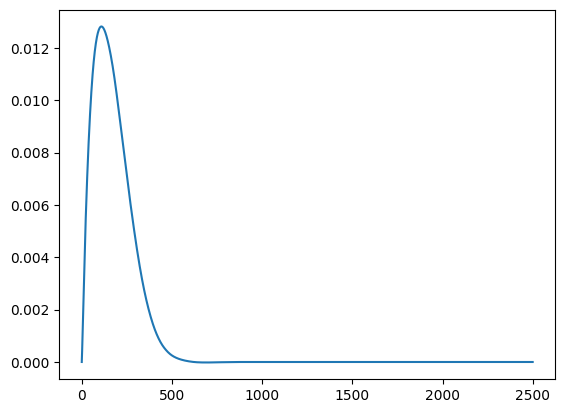

In [117]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [118]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
unitarity_shape_parameter = 0.2
overlap_learning_rate = 150

num_iterations = int(1e4)

In [119]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [120]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [121]:
adam_params = (1e-4, 0.45, 0.45)

In [122]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.9999998879906
6.500611243343532e-16
100
511.998136075432
1.2839906403537778e-10
200
511.9472972146239
5.897653415751301e-09
300
511.4030998680422
4.328541171319491e-08
400
507.5289822371495
2.9235393882760216e-07
500
489.4955230674094
2.6653870609472285e-06
600
458.0372012387406
1.4170614245463507e-05
700
409.3681638661382
2.8750247956428713e-05
800
334.0946357066376
2.985235810214909e-05
900
241.03018789077032
3.3322848203043315e-05
1000
149.67584319130157
5.1472469522191605e-05
1100
89.71676993099612
5.3807045471862795e-05
1200
54.412267215350255
4.402996902355501e-05
1300
21.236358942794823
3.3993812610577736e-05
1400
3.749335628589847
3.879155284491758e-05
1500
0.5321763288108059
4.230148574551617e-05
1600
0.11820140924186262
5.3474758342561425e-05
1700
0.04760826753715719
6.334804474270317e-05
1800
0.0277294822700469
7.034503284006964e-05
1900
0.02052997844748461
7.596708147358919e-05
2000
0.017635697644607262
7.91012859333866e-05
2100
0.015202161595823327
8.08880444959643e-

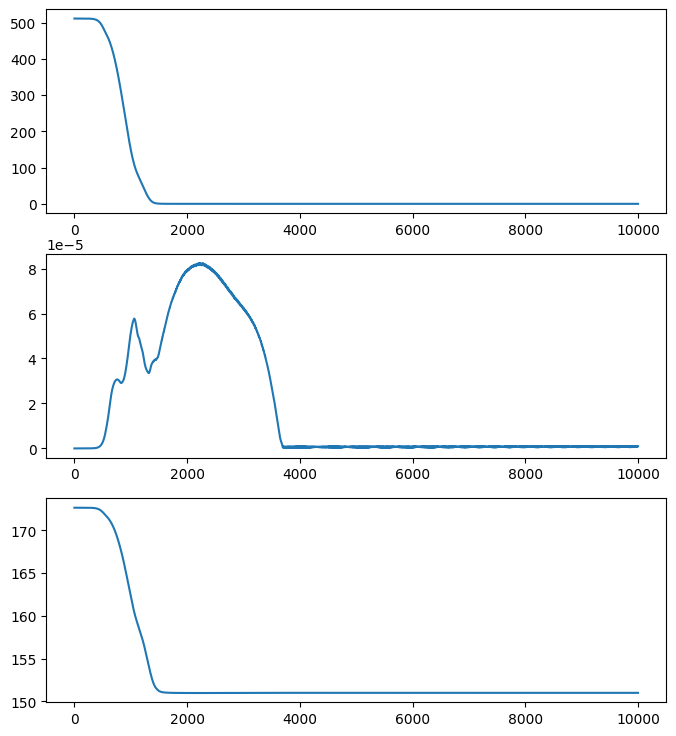

In [123]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

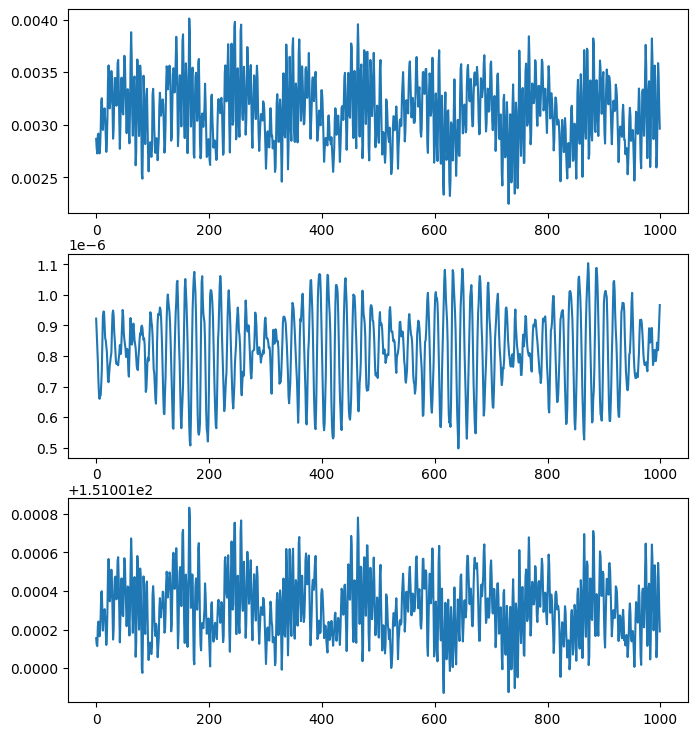

In [124]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[-1000:])
ax2.plot(opt.mpo_expectations[-1000:])
ax3.plot(opt.training_losses[-1000:])

## 6

In [125]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [126]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

109.0036027431488


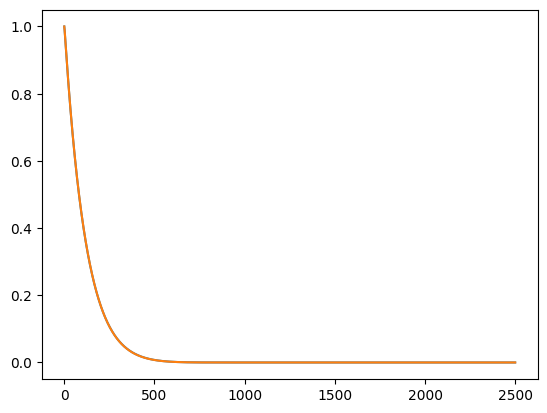

In [127]:
plt.plot(left_scores)
plt.plot(right_scores)

In [128]:
(left_scores[-1], right_scores[-1])

((4.626412784882909e-08-9.89969757102231e-21j),
 (4.9593284041213504e-08-4.12928561781541e-21j))

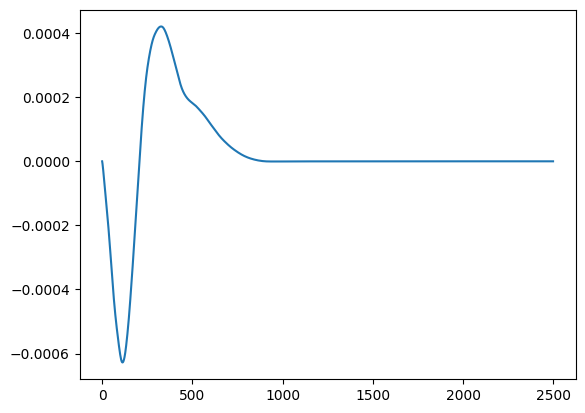

In [129]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [132]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
unitarity_shape_parameter = 0.2
overlap_learning_rate = 250

num_iterations = int(1e4)

In [133]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [134]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [135]:
adam_params = (1e-4, 0.45, 0.45)

In [136]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.99999990109035
8.450435068875525e-15
100
511.99751213889436
2.106208077593005e-10
200
511.92066970515464
4.158519355349334e-09
300
510.9645147353843
4.8613592595962194e-08
400
503.2664265151114
4.3649388276381663e-07
500
473.5610739902347
2.528337460460318e-06
600
424.9121534740383
4.854263648724556e-06
700
338.24015477161396
8.488760950247037e-06
800
218.20444153371727
1.299376922543661e-05
900
104.677814995093
6.394172348386294e-05
1000
36.487623065814944
8.353510634483228e-05
1100
9.333638532207942
8.041241976755703e-05
1200
1.5180036764637066
8.655698136141985e-05
1300
0.21970056898248913
8.53276220616411e-05
1400
0.0683946638046109
7.69084721579277e-05
1500
0.03811632844576707
6.4711649766694e-05
1600
0.026529213691446785
5.243550603984557e-05
1700
0.020336788092038205
4.315538644162838e-05
1800
0.016867298449540158
4.1083846686896355e-05
1900
0.015456219731959209
5.1768543599646196e-05
2000
0.013987555188577971
7.032618074677528e-05
2100
0.012535691893162948
8.7799528095096

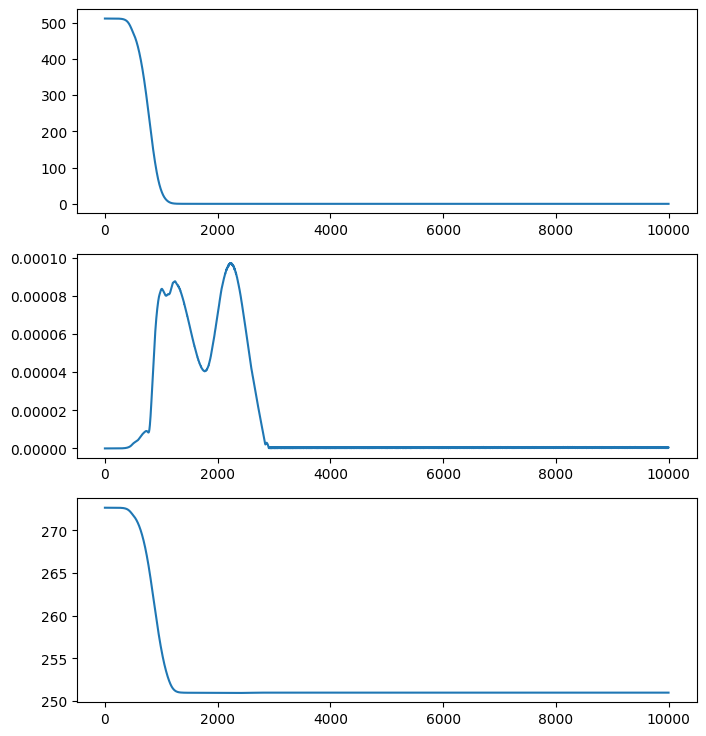

In [137]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

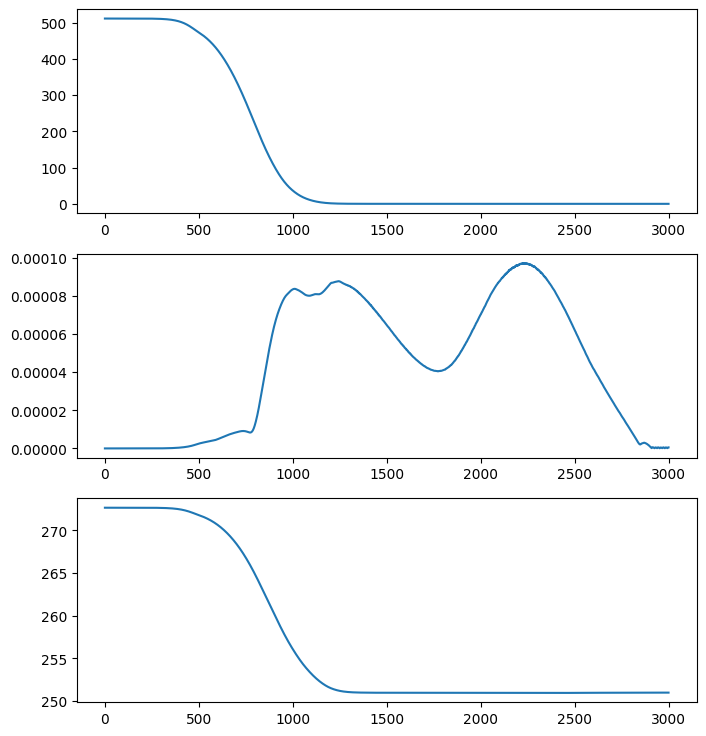

In [138]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[:3000])
ax2.plot(opt.mpo_expectations[:3000])
ax3.plot(opt.training_losses[:3000])

## 7

In [139]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [140]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

105.1467912197113


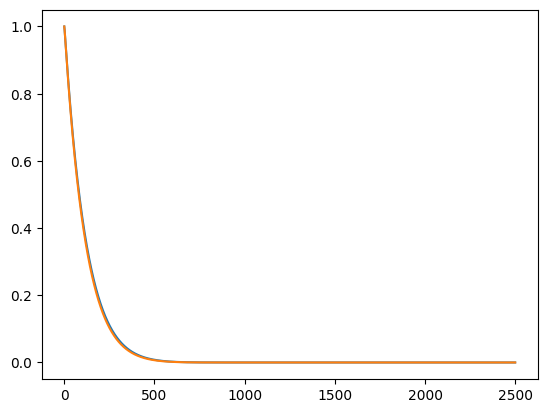

In [141]:
plt.plot(left_scores)
plt.plot(right_scores)

In [142]:
(left_scores[-1], right_scores[-1])

((2.3548082371093383e-08-7.279189390451236e-22j),
 (3.8813406393806577e-08+1.829723514991949e-21j))

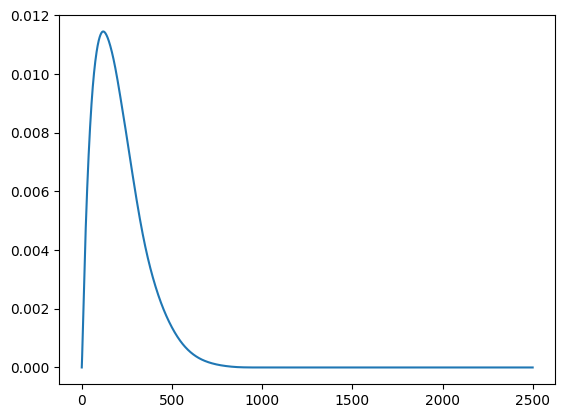

In [143]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [147]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
unitarity_shape_parameter = 0.2
overlap_learning_rate = 1000

num_iterations = int(1e4)

In [148]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [149]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [150]:
adam_params = (1e-4, 0.45, 0.45)

In [151]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.999999922027
9.956089830181751e-16
100
511.9975981362312
2.2560109873354033e-10
200
511.92672859548236
8.818087637541087e-09
300
511.1370278087623
1.5279918213838611e-07
400
505.45183016584804
1.4056702395618987e-06
500
484.32208524731846
8.497533585647272e-06
600
445.8868197375112
2.1478027997414618e-05
700
377.441350251049
4.593152511682865e-05
800
277.98643736280155
0.00014899502237900167
900
161.34775842321648
0.00035779822066572483
1000
68.68351985637031
0.0006508458932365455
1100
27.11936912710405
0.0010865598298574382
1200
10.641545706572458
0.0010754079115161983
1300
4.148176823498261
0.0006268219469465408
1400
1.9789974638216563
0.00019258687847113228
1500
1.2782172133639733
2.5792590726072607e-07
1600
0.6817450601640189
4.922492495521529e-06
1700
0.46995115808311994
5.224552430295187e-06
1800
0.37525186915422637
2.624861084773049e-06
1900
0.29215176139177856
8.961589988017026e-07
2000
0.25249606937859426
1.881293900937427e-06
2100
0.19454847692242083
7.019180324263907e-

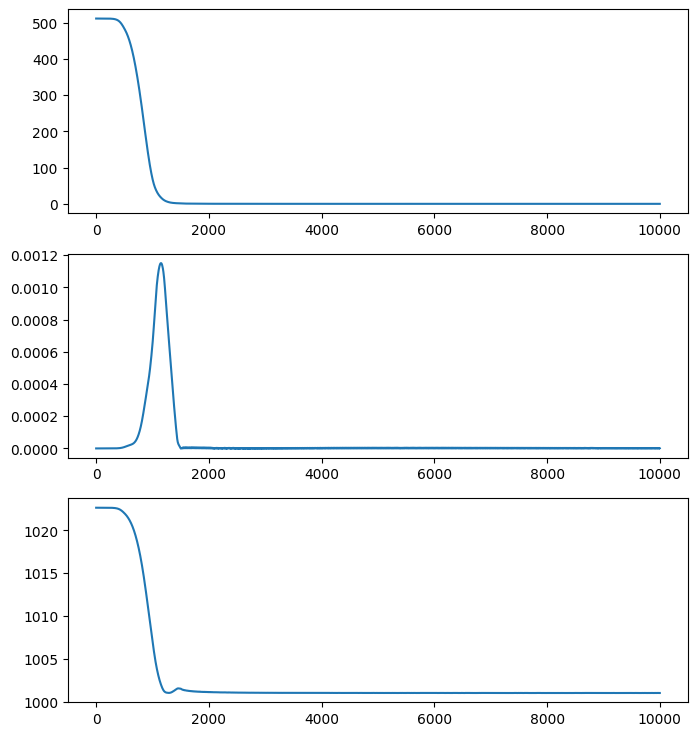

In [153]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

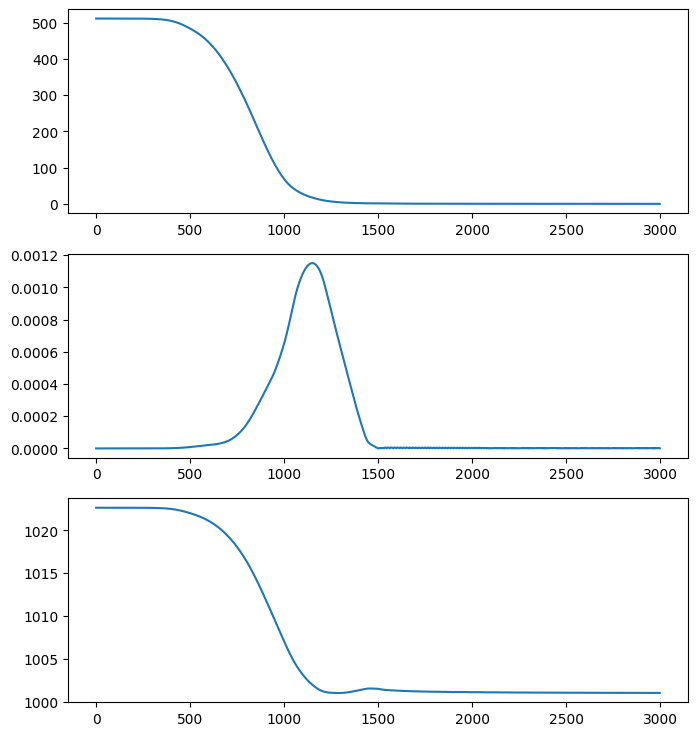

In [154]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[:3000])
ax2.plot(opt.mpo_expectations[:3000])
ax3.plot(opt.training_losses[:3000])

## 8 

In [155]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [156]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

110.49498176574707


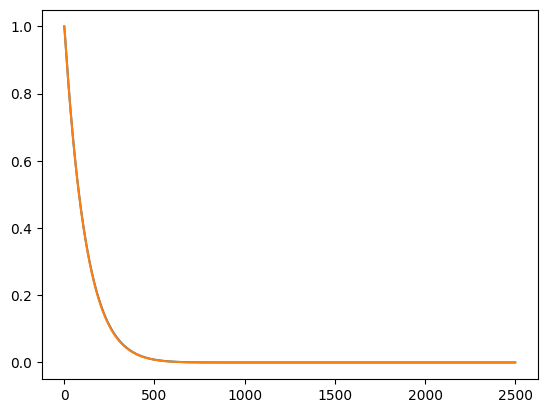

In [157]:
plt.plot(left_scores)
plt.plot(right_scores)

In [158]:
(left_scores[-1], right_scores[-1])

((6.487160408389882e-08-6.458626222818662e-21j),
 (4.8042345465565414e-08+9.661469553633287e-22j))

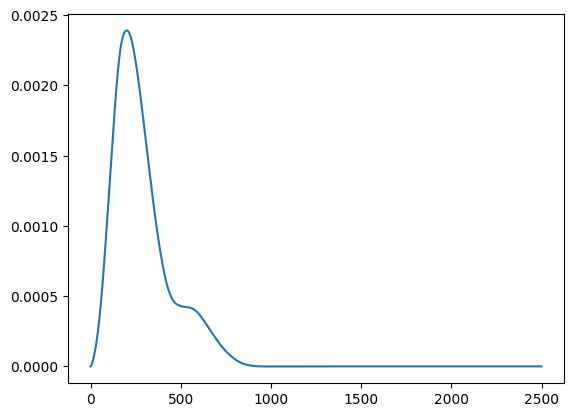

In [159]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [161]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
unitarity_shape_parameter = 0.2
overlap_learning_rate = 200

num_iterations = int(1e4)

In [162]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [163]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [164]:
adam_params = (1e-4, 0.1, 0.1)

In [165]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.99999990487015
2.9662097771271202e-15
100
511.99993745516855
2.3092441839085796e-12
200
511.999145848566
6.452037138942907e-11
300
511.9943602367505
4.634198683164681e-10
400
511.97473747752827
2.1532686020661676e-09
500
511.9096472771865
7.515280045431464e-09
600
511.71813137098627
2.1057544259446595e-08
700
511.2016447071779
5.0320679261149083e-08
800
509.90978579001626
1.0731910802122174e-07
900
506.9429539250099
2.0668011704461174e-07
1000
500.89288227269475
3.606612419694053e-07
1100
490.8353951734746
5.609101818545392e-07
1200
478.7373635721033
8.247615399684684e-07
1300
464.9242386618441
1.5400130569980075e-06
1400
446.73577112760717
2.7414681971290184e-06
1500
422.2860963125405
4.7128817773140905e-06
1600
389.6005478680338
7.8433382853898e-06
1700
346.9696338816624
1.3839643661291427e-05
1800
294.4535875087345
2.162770150845985e-05
1900
234.55144670396783
3.278580034229143e-05
2000
173.668471816556
4.791376863145606e-05
2100
120.75485864022914
7.349686740354748e-05
2200
8

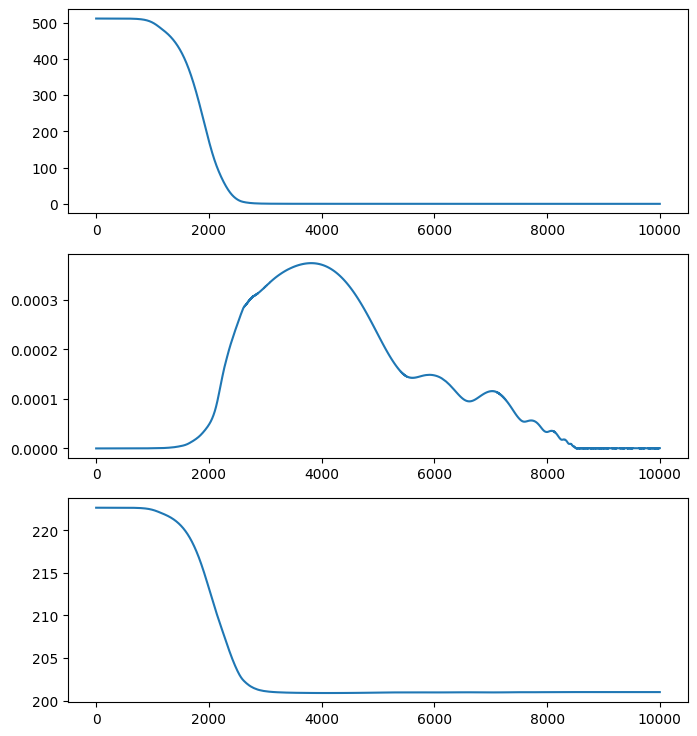

In [167]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

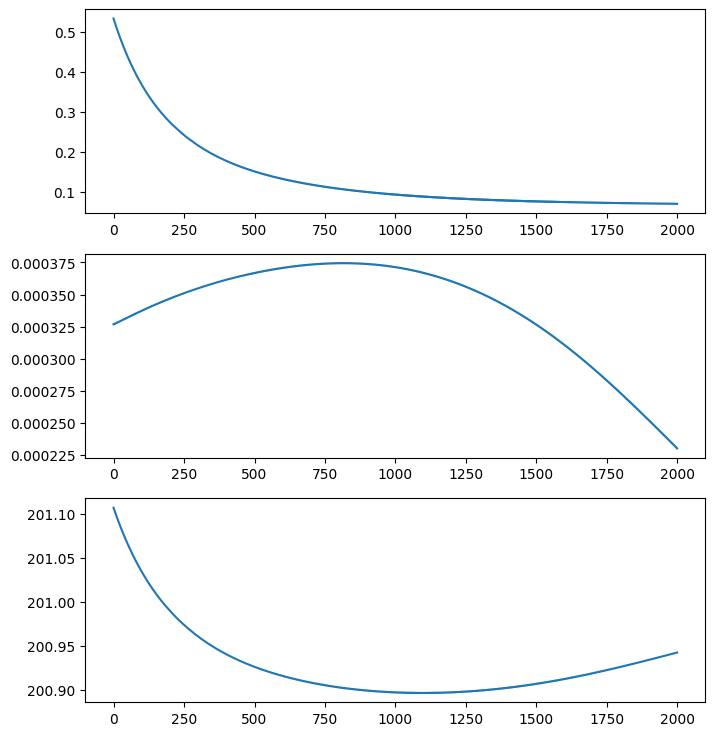

In [169]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[3000:5000])
ax2.plot(opt.mpo_expectations[3000:5000])
ax3.plot(opt.training_losses[3000:5000])

## 9

In [170]:
num_iterations = 2500

num_sites = 6
bond_dimension=6
adam_params = (1e-4, 0.4, 0.4)

In [171]:
start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    case,
    1,
    40,
    adam_params
)

left_scores = list()
right_scores = list()

for _ in range(num_iterations):
    l_score, r_score = two_sided_mpo_rdm_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    left_scores.append(l_score)
    right_scores.append(r_score)

end = time.time()
print(end - start)

105.29716682434082


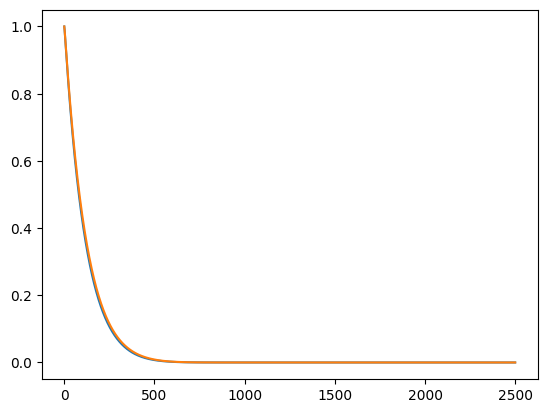

In [172]:
plt.plot(left_scores)
plt.plot(right_scores)

In [173]:
(left_scores[-1], right_scores[-1])

((1.1139190499961078e-09-1.5650257189564913e-21j),
 (4.072557815573669e-08+7.246929346574668e-21j))

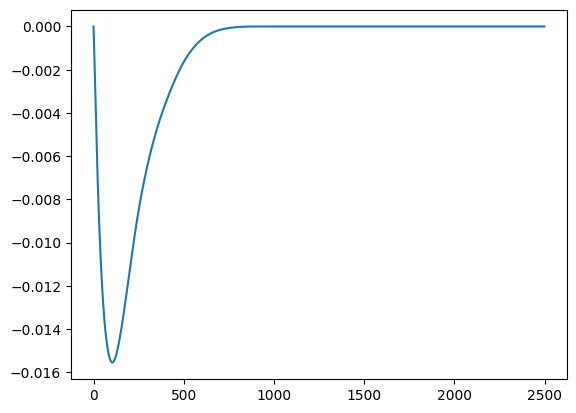

In [174]:
plt.plot(np.array(left_scores) - np.array(right_scores))

Now plug into unitary solver...

In [175]:
num_iterations = int(1e4)
unitarity_learning_rate = 1
unitarity_shape_parameter = 0.2
overlap_learning_rate = 200

num_iterations = int(1e4)

In [176]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [177]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [178]:
adam_params = (1e-4, 0, 0.1)

In [179]:
opt = MPOGradientDescent(
    case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    left_mpo_tensors=left_mpo_tensors,
    right_mpo_tensors=right_mpo_tensors,
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
511.9999999189396
1.2070474034020581e-15
100
511.9999534186237
2.5732521116095427e-13
200
511.99936989985093
3.787534781117121e-11
300
511.99609035675513
3.106039047296764e-10
400
511.9836310165355
6.040378673928665e-10
500
511.94611702712575
1.1451354230847382e-09
600
511.8472176814417
9.433591905812452e-09
700
511.6084404960033
3.4191185379386826e-08
800
511.06801885300706
1.0115272715272119e-07
900
509.9060930861902
2.676383161575096e-07
1000
507.53378141466874
6.503831016543275e-07
1100
502.99503591037154
1.4598323850774896e-06
1200
495.0870647356805
3.104828919012775e-06
1300
483.374264773223
6.386976928196644e-06
1400
469.88030678735504
1.177340486801889e-05
1500
454.3550758559861
1.2024513434570256e-05
1600
434.4859942019938
9.719912170046619e-06
1700
408.96526659852884
7.197740559496847e-06
1800
376.73947313740535
4.888081199401604e-06
1900
337.10641365445684
1.1679000104539029e-05
2000
290.78728153250256
3.1488522771308624e-05
2100
239.51600080161734
6.463500580348151e-05
22

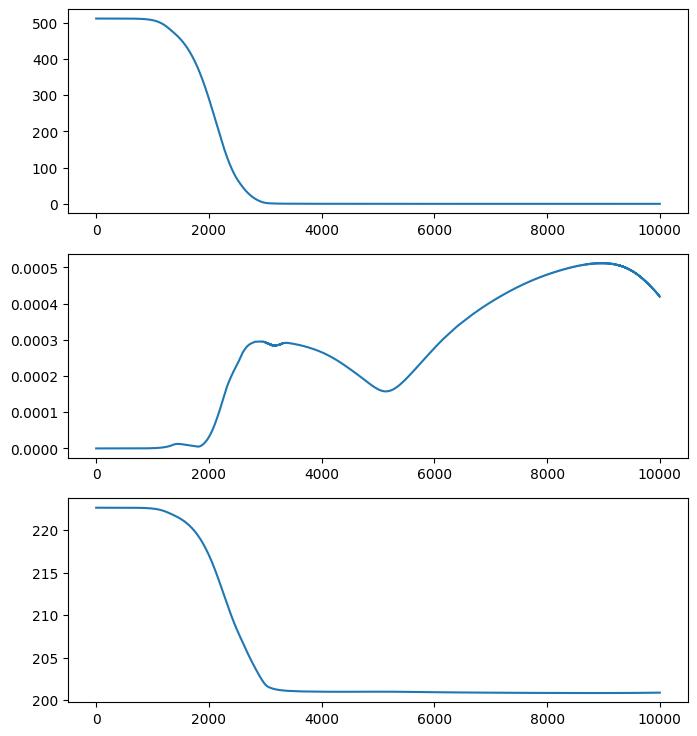

In [181]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

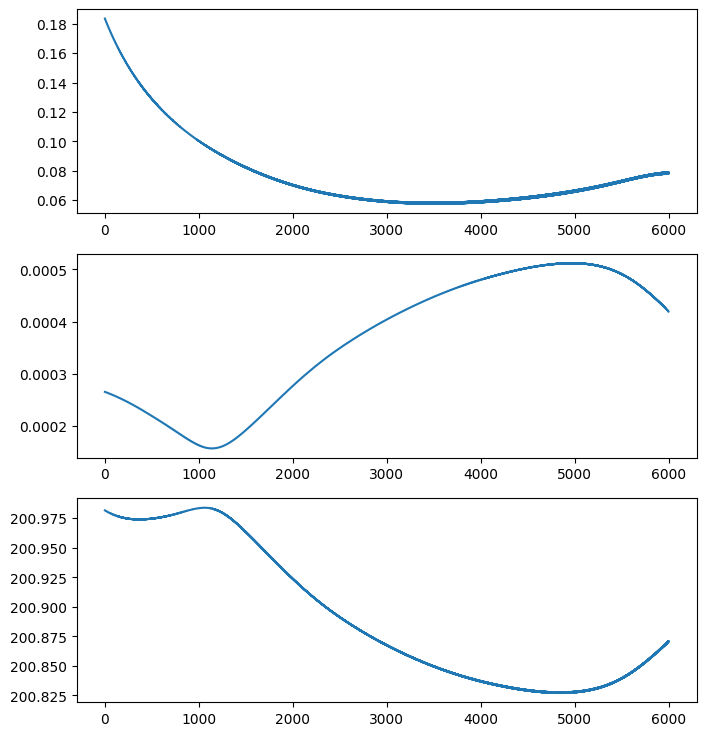

In [184]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[4000:])
ax2.plot(opt.mpo_expectations[4000:])
ax3.plot(opt.training_losses[4000:])

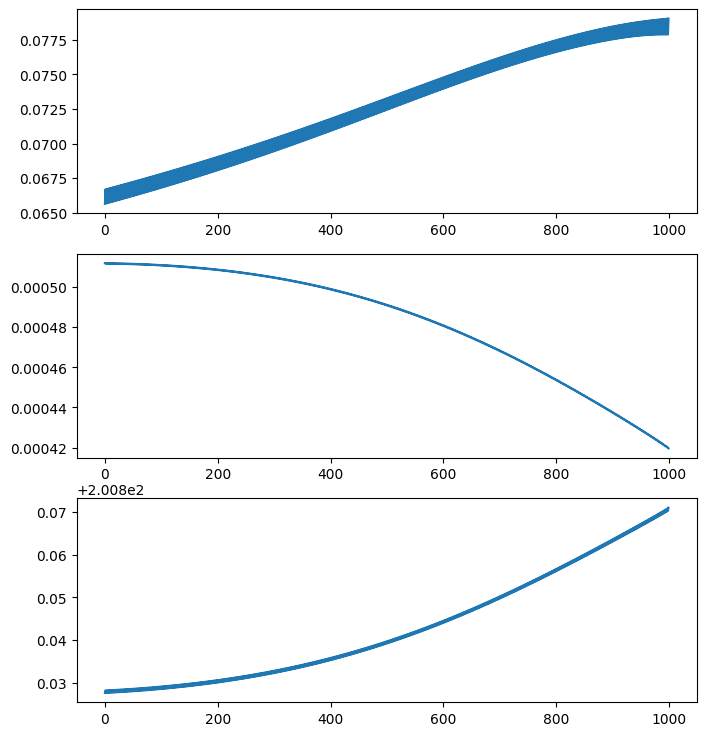

In [185]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[9000:])
ax2.plot(opt.mpo_expectations[9000:])
ax3.plot(opt.training_losses[9000:])

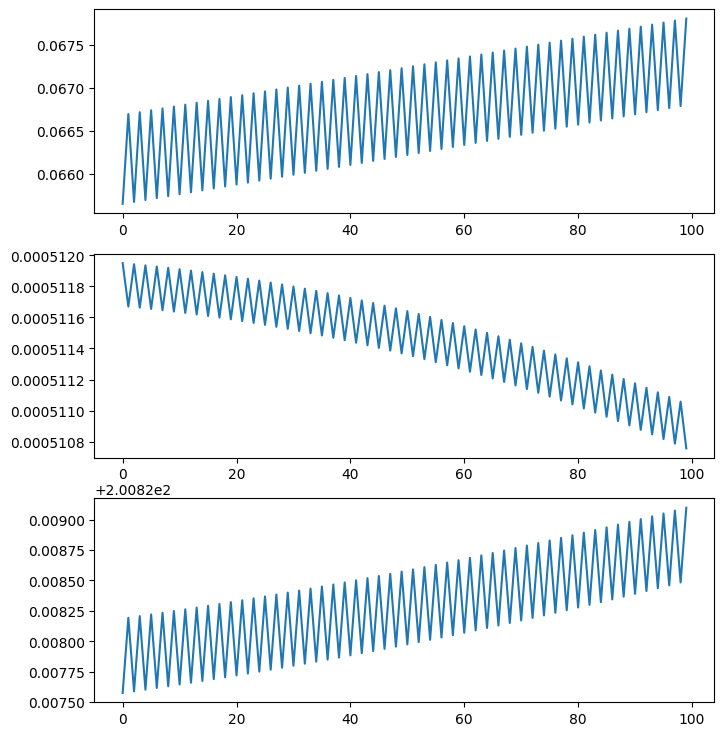

In [186]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores[9000:9100])
ax2.plot(opt.mpo_expectations[9000:9100])
ax3.plot(opt.training_losses[9000:9100])